In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    
def createDictionary(dataframe_col1, dataframe_col2):
    """
    returns dictionary of structure number as key and and list of attribute belonging  to structure number
    :rtype: dictionary
    
    """
    # initialize the dictionary
    dictionary = {structure_number:[] for structure_number in dataframe_col1}
    
    for structure_number, value in zip(dataframe_col1, dataframe_col2):
        dictionary[structure_number].append(value)
    return dictionary


def createDictionaryOfMeanValue(dictionary):
    """
    returns dictionary of structure number as key and and mean values in corresponding to the structure number
    :rtype: dictionary
    
    """
    dictionary_new = {}
    
    for key, value in dictionary.items():
        mean_value = np.mean(value)
        dictionary_new[key] = mean_value
        
    return dictionary_new

def createDictionaryOfFirstValue(dictionary):
    dictionary_new = {}
    
    for key, value in dictionary.items():
        value = value[0]
        dictionary_new[key] = value
        
    return dictionary_new


### Importing dataset

In [3]:
df_csv = pd.read_csv('../data-generation/NE_Counties_MERRA_by_bridge.csv', index_col=0)
d_structureNumber_county = createDictionary(df_csv['structure_number'],df_csv['COUNTY_NAME'])
d_structureNumber_freeze_thaw = createDictionary(df_csv['structure_number'],df_csv['NO_OF_FREEZE_THAW_CYCLES'])

### Dataset

In [4]:
df_csv.head(10)

,structure_number,county_code,COUNTY_NAME,year,NO_OF_FREEZE_THAW_CYCLES,no_of_snowfalls
state_code,,,,,,
31,C000100305P,1.0,Adams County,1980.0,115.0,57.0
31,C000100305P,1.0,Adams County,1981.0,101.0,33.0
31,C000100305P,1.0,Adams County,1982.0,105.0,56.0
31,C000100305P,1.0,Adams County,1983.0,99.0,88.0
31,C000100305P,1.0,Adams County,1984.0,133.0,68.0
31,C000100305P,1.0,Adams County,1985.0,99.0,62.0
31,C000100305P,1.0,Adams County,1986.0,112.0,36.0
31,C000100305P,1.0,Adams County,1987.0,113.0,46.0
31,C000100305P,1.0,Adams County,1988.0,112.0,43.0


### Creating a dictionary

In [5]:
d_freeze_thaw = createDictionaryOfMeanValue(d_structureNumber_freeze_thaw)

### Importing NBI data

In [6]:
csv_file = "../data-generation/04-28-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

### Data Preprocessing

In [7]:
df_wo = df_wo[df_wo['No Change structure length'] == True]
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]
df_wo = df_wo[df_wo['Structure Length']>6]

In [8]:
NE = df_wo[df_wo['State Code'] == 31]
NE['SN'] = [structureNumber[:-2] for structureNumber in NE['Structure Number']]
NE['No. of Freeze Thaw'] = NE['SN'].map(d_freeze_thaw) 
NE_clean = NE.dropna()

In [9]:
NE_clean.shape

(8859, 30)

## Data visualization 

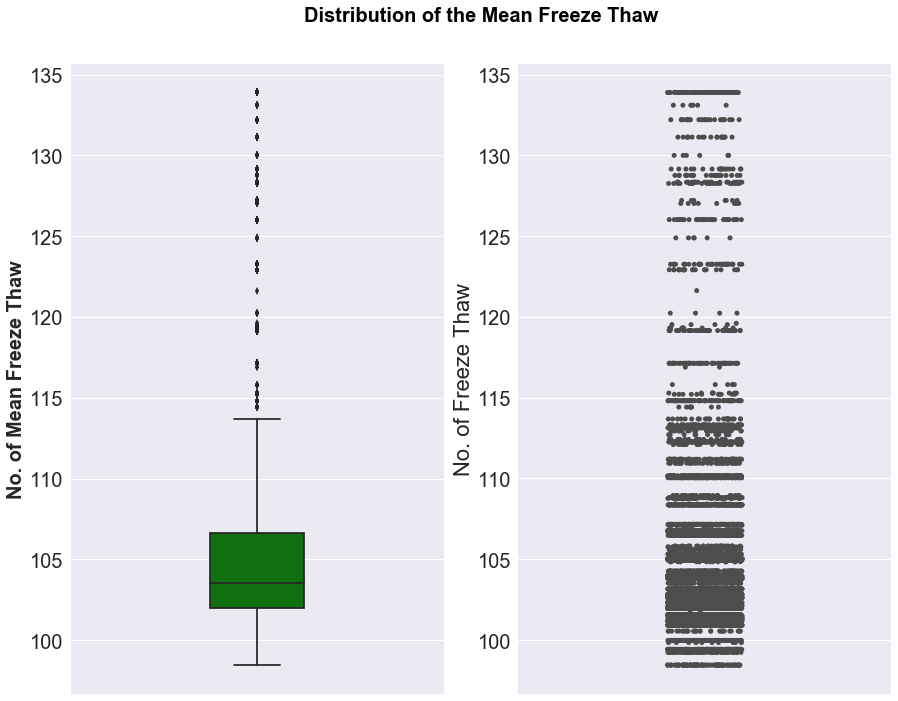

In [10]:
# mean_freezethaw = list(d_freeze_thaw.values())
# Q1 = NE_clean['No. of Freeze Thaw'].quantile(0.25)
# Q3 = NE_clean['No. of Freeze Thaw'].quantile(0.75)
# IQR = Q3 - Q1

# df_new = NE_clean[NE_clean['No. of Freeze Thaw'] < (Q3+1.5*IQR)]
# df_anova = df_new[df_new['No. of Freeze Thaw'] > (Q1+1.5*IQR)]

plt.figure(figsize=(12,10))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Distribution of the Mean Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)
plt.subplot(1,2,1)
sns.boxplot(x = NE_clean['No. of Freeze Thaw'],  color = 'Green', orient='v', width = 0.25)
plt.ylabel("No. of Mean Freeze Thaw", fontsize = 20, fontweight = "bold")

plt.subplot(1,2,2)
sns.stripplot(y= NE_clean['No. of Freeze Thaw'], jitter=True, color=".3")
plt.show()

In [11]:
NE_clean['freezethaw'] = pd.qcut(NE_clean['No. of Freeze Thaw'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = NE_clean[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code',
                       'Material','Structure Type', 'Maintainer','freezethaw', 'No. of Freeze Thaw']]


df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               'freezethaw':'freezethaw',\
                                               'No. of Freeze Thaw':'numfreezethaw'
                                               
                                              })

### Number of records after removing outliers 

In [12]:
df_anova.shape

(8859, 10)

### Bar chart

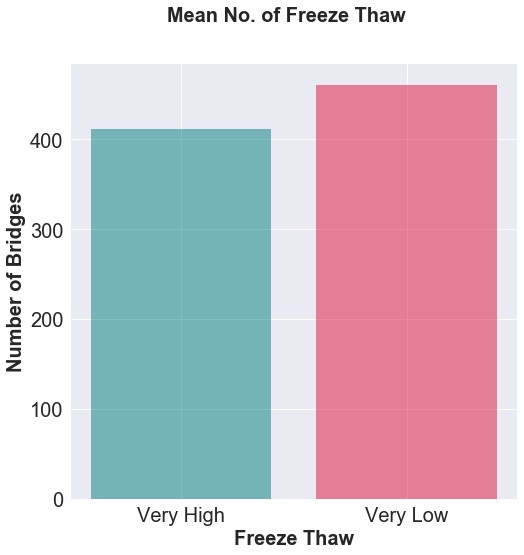

In [13]:
count_freezethaw = df_anova.groupby('freezethaw')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Mean No. of Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Low", "Very High"]
no_of_records = [count_freezethaw[0], count_freezethaw[2]]
plt.bar(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("Freeze Thaw", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

#### Small sample analysis

In [19]:
freezethaw_small = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))
freezethaw = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['freezethaw'].tolist()
score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(100))['score'].tolist()
df_freezethaw_sample_100 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_100 = df_freezethaw_sample_100[df_freezethaw_sample_100['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_100, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),11.516657,1.0,14.184533,0.000218,0.06685,0.061846
Residual,160.759474,198.0,NaN,NaN,NaN,NaN


#### Large sample analysis

In [20]:
samplesize = min(df_anova.groupby(['freezethaw'])['freezethaw'].count())
freezethaw = df_anova.groupby('freezethaw').apply(lambda s: s.sample(samplesize))['freezethaw'].tolist()
score = df_anova.groupby('freezethaw').apply(lambda s: s.sample(samplesize))['score'].tolist()
df_freezethaw_sample_45121 = pd.DataFrame({'freezethaw':freezethaw, 'score':score})
df_freezethaw_45121 = df_freezethaw_sample_45121[df_freezethaw_sample_45121['freezethaw'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(freezethaw)'
freezethaw_undersample = undersample(df_freezethaw_45121, 'freezethaw')
aov(freezethaw_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(freezethaw),68.860262,1.0,84.860331,2.612382e-19,0.093576,0.092371
Residual,667.015250,822.0,NaN,NaN,NaN,NaN


## Further analysis

### Very High Freezethaw 

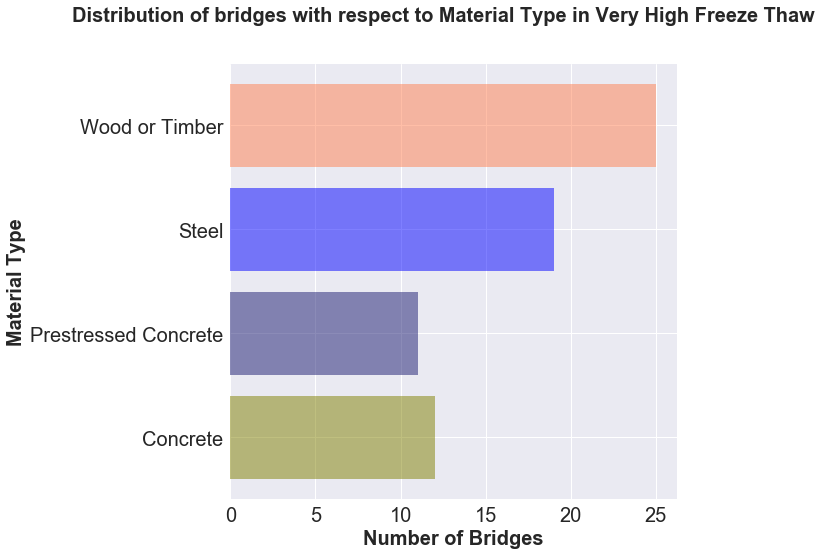

In [24]:
scores_high = freezethaw_small[freezethaw_small['freezethaw'] == 'Very High']
scores_high['materialname'] = retMaterialNames(scores_high['material'])

#low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very High Freeze Thaw ", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Count of the bridges with respect to material name with high number of Freeze Thaw

In [23]:
scores_high.groupby('materialname')['materialname'].count()

materialname
Concrete                           12
Concrete Continuous                22
Prestressed Concrete               11
Prestressed Concrete Continuous     2
Steel                              19
Steel Continuous                    9
Wood or Timber                     25
Name: materialname, dtype: int64

### Very Low Freezethaw

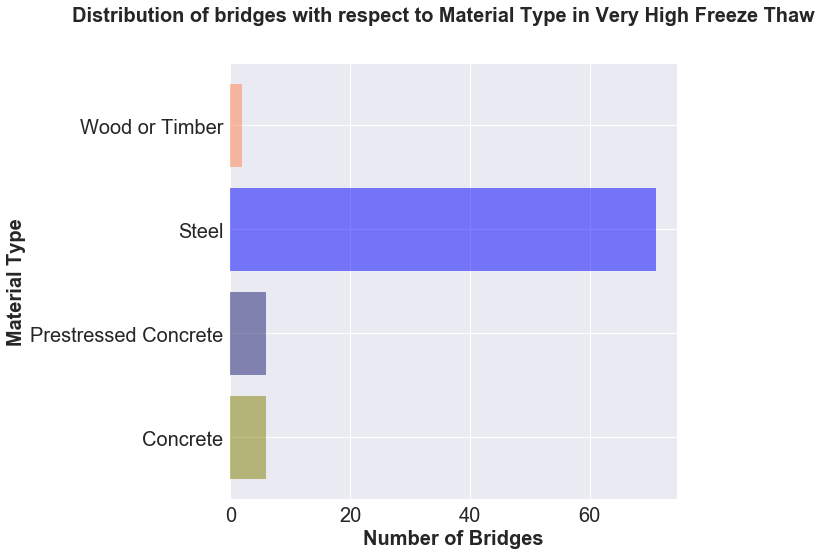

In [25]:
scores_low = freezethaw_small[freezethaw_small['freezethaw'] == 'Very Low']
scores_low['materialname'] = retMaterialNames(scores_low['material'])

#low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
low_mat = scores_low[scores_low['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very High Freeze Thaw ", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Count of the bridges with respect to material name with very low number of Freeze Thaw

In [26]:
scores_high.groupby('materialname')['materialname'].count()

materialname
Concrete                           12
Concrete Continuous                22
Prestressed Concrete               11
Prestressed Concrete Continuous     2
Steel                              19
Steel Continuous                    9
Wood or Timber                     25
Name: materialname, dtype: int64

## Result without outliers in the freeze-thaw

### Data Visualization

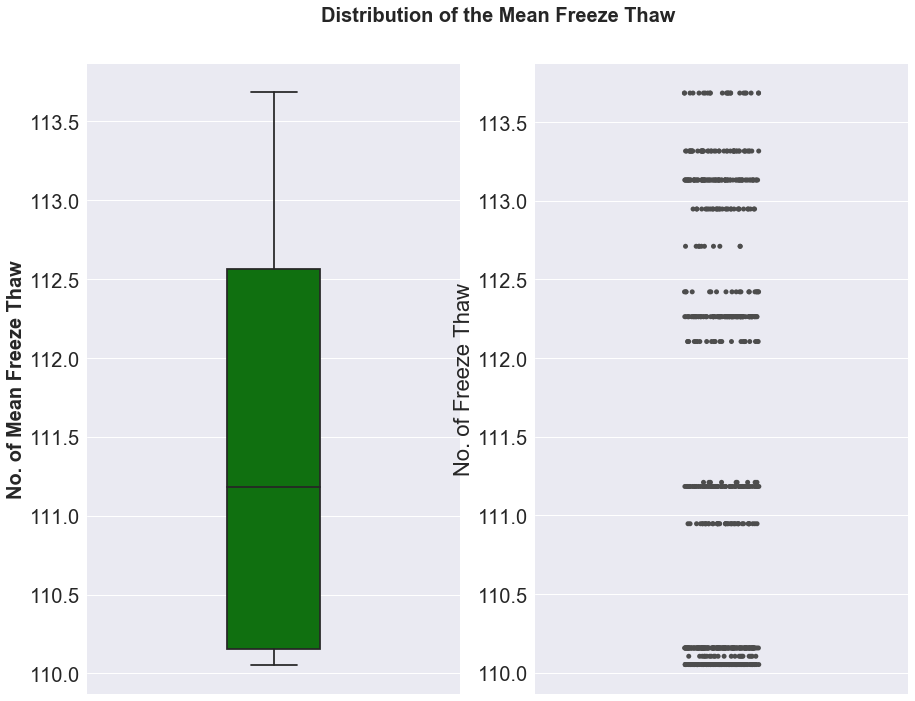

In [38]:
mean_freezethaw = list(d_freeze_thaw.values())
Q1 = NE_clean['No. of Freeze Thaw'].quantile(0.25)
Q3 = NE_clean['No. of Freeze Thaw'].quantile(0.75)
IQR = Q3 - Q1

df_new = NE_clean[NE_clean['No. of Freeze Thaw'] < (Q3+1.5*IQR)]
df_anova = df_new[df_new['No. of Freeze Thaw'] > (Q1+1.5*IQR)]

plt.figure(figsize=(12,10))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Distribution of the Mean Freeze Thaw", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)
plt.subplot(1,2,1)
sns.boxplot(x = df_anova['No. of Freeze Thaw'],  color = 'Green', orient='v', width = 0.25)
plt.ylabel("No. of Mean Freeze Thaw", fontsize = 20, fontweight = "bold")

plt.subplot(1,2,2)
sns.stripplot(y= df_anova['No. of Freeze Thaw'], jitter=True, color=".3")
plt.show()

### Number of records present after removing outliers

In [47]:
df_anova['freezethaw'] = pd.qcut(df_anova['No. of Freeze Thaw'],[0, 0.50, 0], labels = ['Very Low','Very High'])



ValueError: Bin edges must be unique: array([110.05263158, 111.18421053, 110.05263158]).
You can drop duplicate edges by setting the 'duplicates' kwarg

The values of mean number of mean freeze thaw are concentrated between a very small interval.